In [20]:
from tqdm.notebook import tqdm
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import cv2
import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/HodaDatasetReader')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
from HodaDatasetReader import read_hoda_cdb, read_hoda_dataset

trainImages, trainLabels = read_hoda_cdb('/content/drive/MyDrive/HodaDatasetReader/DigitDB/Train 60000.cdb')
testImages, testLabels = read_hoda_cdb('/content/drive/MyDrive/HodaDatasetReader/DigitDB/Test 20000.cdb')


Optimal height is 64 and optimal width is 64


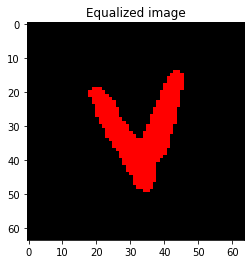

In [31]:
num_classes = 10
y_train = keras.utils.to_categorical(trainLabels, num_classes)
y_test = keras.utils.to_categorical(testLabels, num_classes)

def resizeImage(img, h, w):
    ret = np.zeros((h,w), np.uint8)
    padTop = (h-img.shape[0])//2
    padLeft = (w-img.shape[1])//2
    ret[padTop:img.shape[0]+padTop, padLeft:padLeft+img.shape[1]] = img
    ret2 = np.zeros((h,w,3), np.uint8)
    ret2[:,:,0] = ret
    return ret2

allImages = trainImages+testImages

w_max = 0
h_max = 0

for i in tqdm(range(len(allImages))):
    h_max, w_max = max(h_max, allImages[i].shape[0]), max(w_max, allImages[i].shape[1])

print ("Optimal height is %d and optimal width is %d" % (max(h_max, w_max), max(h_max, w_max)))


for i in range(len(allImages)):
    allImages[i] = resizeImage(allImages[i], max(h_max, w_max), max(h_max, w_max))

trainImages, testImages = allImages[0:len(trainImages)], allImages[len(trainImages):]

x_train = np.array(trainImages,np.float32)/255
x_test = np.array(testImages, np.float32)/255

plt.title("Equalized image")
plt.imshow(trainImages[4])
plt.show()


In [32]:
# define model with pooling
model = keras.Sequential()
model.add(keras.layers.Input(shape=x_train[0].shape))
model.add(keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Flatten(input_shape=x_train[0].shape))
model.add(keras.layers.Dense(units=120, activation='relu'))
model.add(keras.layers.Dense(units=84, activation='relu'))
model.add(keras.layers.Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 60, 60, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               324600    
_________________________________________________________________
dense_1 (Dense)              (None, 84)               

In [33]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
history = model.fit(x_train, y_train,
                    batch_size=100,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    shuffle=True)

Epoch 1/10
600/600 [==============================] - 12s 8ms/step - loss: 0.3749 - accuracy: 0.8907 - val_loss: 0.0931 - val_accuracy: 0.9714
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0356 - accuracy: 0.9886 - val_loss: 0.0558 - val_accuracy: 0.9822
Epoch 3/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0587 - val_accuracy: 0.9812
Epoch 4/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.0424 - val_accuracy: 0.9875
Epoch 5/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0478 - val_accuracy: 0.9867
Epoch 6/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.0470 - val_accuracy: 0.9871
Epoch 7/10
600/600 [==============================] - 5s 8ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0439 - val_accuracy: 0.9884
Epoch

Text(0.5, 1.0, 'Confusion matrix')

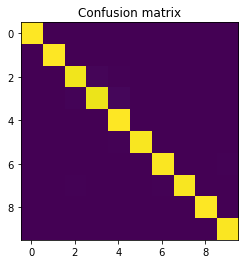

In [36]:
# plot confusion matrix
import sklearn.metrics

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize=None)

plt.imshow(conf)
plt.title("Confusion matrix")